In [87]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from idqn.utils.plots import confidence_interval_bootstrap
from idqn.utils.dopamine_scores import get_dopamine_scores

game = "Breakout"

experiment_names = [
    f"DQN/{game}/DQN/"
]
experiment_labels = [
    "DQN"
]
seeds = [1, 2]

p = json.load(open(f"figures/{experiment_names[0].split('/')[0]}/parameters.json"))

n_seeds = len(seeds)
ticks_freq = 40

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [88]:
dopamine_j = get_dopamine_scores(game)
dopamine_j_1 = get_dopamine_scores(game) + np.random.randint(-15, 15, (5, 200))
dopamine_j_2 = get_dopamine_scores(game) + np.random.randint(-15, 15, (5, 200))

idqn_j = np.zeros((len(experiment_names), n_seeds, p["n_epochs"])) * np.nan

for idx_experiment, experiment_name in enumerate(experiment_names):
    for idx_seed, seed in enumerate(seeds):
        idqn_j[idx_experiment, idx_seed] = np.load(f"figures/{experiment_name}J_{seed}.npy")

### Performances

In [89]:
dopamine_j_mean = dopamine_j.mean(axis=0)
dopamine_j_confidence_interval = confidence_interval_bootstrap(dopamine_j)

dopamine_j_1_mean = dopamine_j_1.mean(axis=0)
dopamine_j_1_confidence_interval = confidence_interval_bootstrap(dopamine_j_1)

dopamine_j_2_mean = dopamine_j_2.mean(axis=0)
dopamine_j_2_confidence_interval = confidence_interval_bootstrap(dopamine_j_2)


idqn_j_mean = idqn_j.mean(axis=1)
idqn_j_confidence_interval = np.zeros((len(experiment_names), 2, p["n_epochs"]))

for idx_experiment in range(len(experiment_names)):
    idqn_j_confidence_interval[idx_experiment] = confidence_interval_bootstrap(idqn_j[idx_experiment])

/home/theo/iDQN/env_cpu/lib/python3.8/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


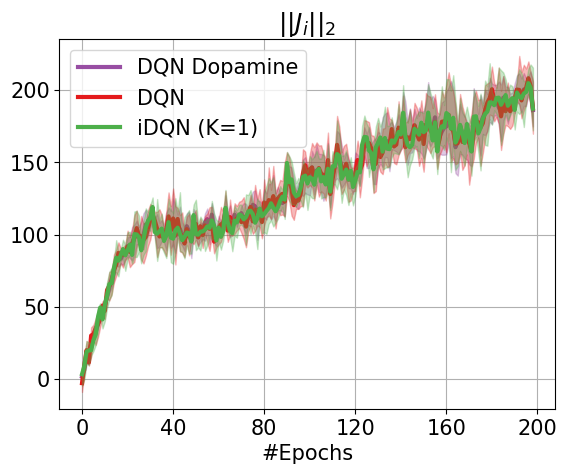

In [90]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(0, p["n_epochs"])

plt.plot(iterations, dopamine_j_mean, label="DQN Dopamine", color=colors["0"], zorder=2)
plt.fill_between(iterations, dopamine_j_confidence_interval[0], dopamine_j_confidence_interval[1], color=colors["0"], alpha=0.3, zorder=2)

plt.plot(iterations, dopamine_j_1_mean, label="DQN", color=colors["1"], zorder=2)
plt.fill_between(iterations, dopamine_j_1_confidence_interval[0], dopamine_j_1_confidence_interval[1], color=colors["1"], alpha=0.3, zorder=2)

plt.plot(iterations, dopamine_j_2_mean, label="iDQN (K=1)", color=colors["2"], zorder=2)
plt.fill_between(iterations, dopamine_j_2_confidence_interval[0], dopamine_j_2_confidence_interval[1], color=colors["2"], alpha=0.3, zorder=2)

# for idx_experiment, experiment_name in enumerate(experiment_names):
#     plt.plot(iterations, idqn_j_mean[idx_experiment], label=experiment_labels[idx_experiment], color=colors[f"{idx_experiment + 1}"], zorder=2)
#     plt.fill_between(iterations, idqn_j_confidence_interval[idx_experiment, 0], idqn_j_confidence_interval[idx_experiment, 1], color=colors[f"{idx_experiment + 1}"], alpha=0.3, zorder=2)

plt.xticks(range(0, p["n_epochs"] + 1, ticks_freq))
plt.xlabel("#Epochs")
plt.title(r"$|| J_i ||_2$")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_names[0]}/J.pdf", bbox_inches='tight')